# Facial Expression Recognition: Bias Detection Through Clustering

This notebook demonstrates the process of analyzing racial biases in facial expression recognition (FER) systems using the UTKFace dataset. The goal is to explore how clustering in latent feature space can expose imbalances and biases, particularly in underrepresented groups.

## 1. Introduction

This section outlines the goal of the project: to detect racial biases in FER systems using clustering techniques. The analysis uses the UTKFace dataset, where images are labeled with metadata such as age, gender, and ethnicity. The project applies unsupervised clustering to identify patterns and imbalances.

## 2. Dataset Loading and Preprocessing

Steps for loading the UTKFace dataset, parsing metadata, and resizing images for consistency.

In [1]:
#Imports

from IPython.display import display
import kagglehub
import os
import pandas as pd
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.models import Model
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
import random
from sklearn.cluster import KMeans


In [2]:
dataset_path = kagglehub.dataset_download("jangedoo/utkface-new")

print("Files:", os.listdir(dataset_path))

# Explore each folder
for folder in os.listdir(dataset_path):
    folder_path = os.path.join(dataset_path, folder)
    if os.path.isdir(folder_path):
        print(f"Files in {folder}:")
        print(os.listdir(folder_path)[:5])  # Preview first 5 files




100%|██████████| 331M/331M [00:03<00:00, 110MB/s]

Extracting files...


Files: ['crop_part1', 'UTKFace', 'utkface_aligned_cropped']
Files in crop_part1:
['20_1_4_20170103224540624.jpg.chip.jpg', '22_0_3_20170104230122361.jpg.chip.jpg', '2_0_2_20161219162343270.jpg.chip.jpg', '4_1_0_20170109192828745.jpg.chip.jpg', '4_1_2_20161219190303315.jpg.chip.jpg']
Files in UTKFace:
['35_1_4_20170117203326008.jpg.chip.jpg', '89_1_0_20170120225533673.jpg.chip.jpg', '67_0_3_20170117134845691.jpg.chip.jpg', '43_0_2_20170116192612780.jpg.chip.jpg', '25_1_1_20170112205059883.jpg.chip.jpg']
Files in utkface_aligned_cropped:
['crop_part1', 'UTKFace']


`utkface_aligned_cropped` appears to be a copy of the first two folders. So, I decided to use `crop_part1` because this folder contained images that had already been prepped.

In [3]:
# Load images

# I decided to use crop_part1 because these are easier to process
# since they don't require manual alignment or cropping.
chosen_path = os.path.join(dataset_path, 'crop_part1')

# List image files
image_files = [os.path.join(chosen_path, f) for f in os.listdir(chosen_path)
if f.endswith('.jpg')]

# Parse metadata from filenames
def parse_labels(file_name):
    age, gender, ethnicity = file_name.split('_')[:3]
    return int(age), int(gender), int(ethnicity)

# Load a few images and parse labels
data = []
labels = []
for img_path in image_files[:500]:  # Limit for quick testing
    img = Image.open(img_path).resize((224, 224))
    img_array = np.array(img) / 255.0  # Normalize pixels
    age, gender, ethnicity = parse_labels(os.path.basename(img_path))
    data.append(img_array)
    labels.append([age, gender, ethnicity])

# Convert to numpy arrays
data = np.array(data)
labels = np.array(labels)
print(f"Data shape: {data.shape}, Labels shape: {labels.shape}")



Data shape: (500, 224, 224, 3), Labels shape: (500, 3)


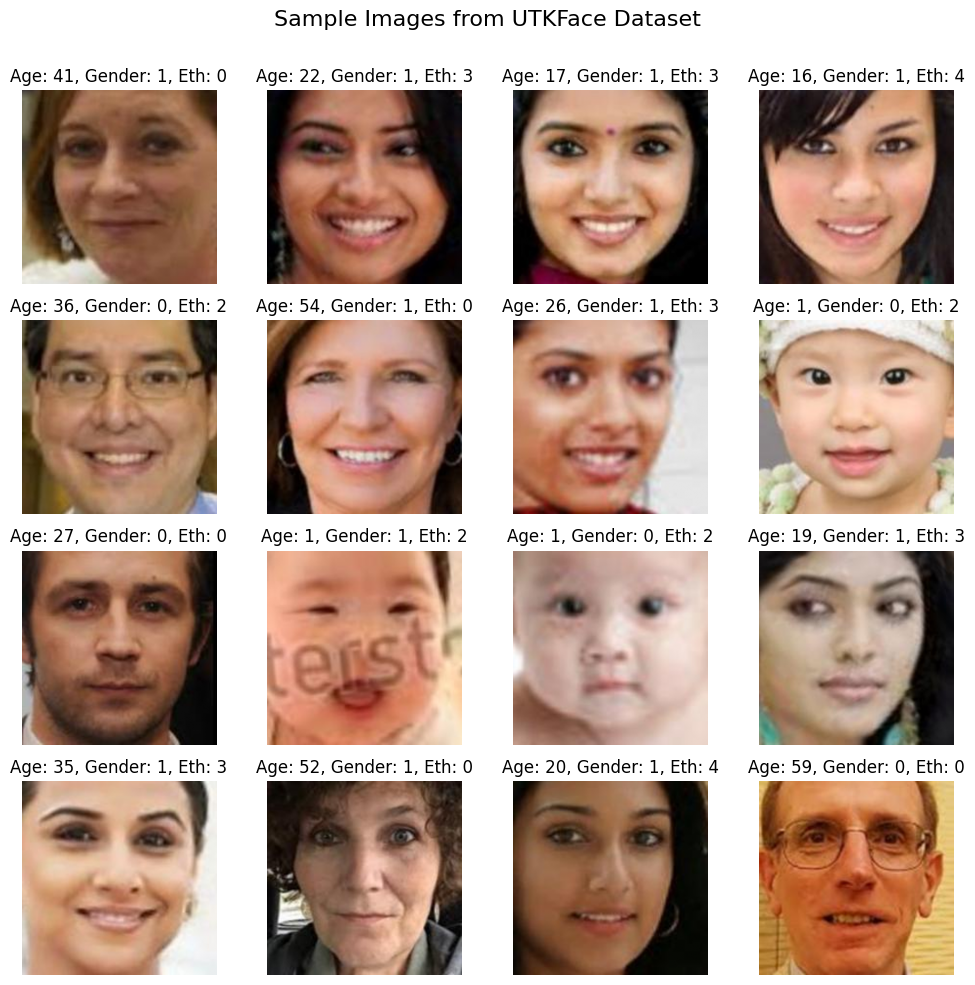

In [4]:
# Preview Images
def show_images(images, labels, num_images=9):
    """
    Display a grid of images with corresponding metadata labels.
    """
    # Determine grid size
    grid_size = int(num_images ** 0.5)

    # Create figure
    fig, axes = plt.subplots(grid_size, grid_size, figsize=(10, 10))
    fig.suptitle("Sample Images from UTKFace Dataset", fontsize=16)

    for i, ax in enumerate(axes.flat):
        if i < len(images):
            ax.imshow(images[i])
            age, gender, ethnicity = labels[i]
            ax.set_title(f"Age: {age}, Gender: {gender}, Eth: {ethnicity}")
            ax.axis('off')  # Remove axes
        else:
            ax.axis('off')  # Hide any empty subplots

    plt.tight_layout()
    plt.subplots_adjust(top=0.9)  # Adjust title position
    plt.show()

# Display 16 sample images
indices = random.sample(range(len(data)), 16)  # Select 16 random images
show_images(data[indices], labels[indices], num_images=16)


## 3. Feature Extraction

This section describes how latent features are extracted from images using a pre-trained ResNet50 model.

In [5]:
# Load pretrained ResNet50 model
base_model = ResNet50(weights='imagenet', include_top=False, pooling='avg')

# Extract features
features = base_model.predict(data)
print(f"Extracted features shape: {features.shape}")

94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 86s 5s/step
Extracted features shape: (500, 2048)


## 4. Clustering and Analysis

Unsupervised clustering is performed using K-Means to group images based on their latent features. This step includes analyzing the distribution of racial groups across clusters.

### Finding the Optimal Number of Clusters (Elbow Method)
An elbow plot is used to determine the optimal number of clusters (k) by evaluating how inertia changes as the number of clusters increases. The goal is to balance simplicity and fit quality by choosing the elbow point in the curve.


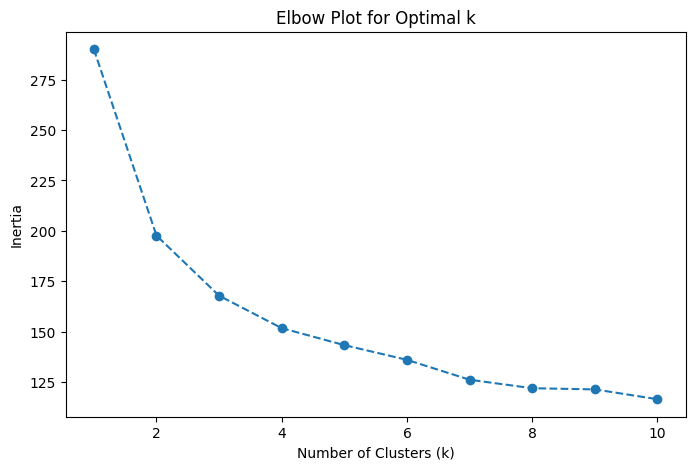

In [6]:
# Get elbow plot

# Range of cluster numbers to try
cluster_range = range(1, 11)
inertias = []

# Fit K-Means for each k and calculate inertia
for k in cluster_range:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(features)  # 'features' should contain the extracted latent features
    inertias.append(kmeans.inertia_)

# Plot the results
plt.figure(figsize=(8, 5))
plt.plot(cluster_range, inertias, marker='o', linestyle='--')
plt.xlabel("Number of Clusters (k)")
plt.ylabel("Inertia")
plt.title("Elbow Plot for Optimal k")
plt.show()


Looking at the elbow plot, the optimal number of clusters appears to be around 3 or 4, as the curve starts to flatten at these points. Beyond 4, the inertia decreases more gradually, indicating diminishing returns from adding more clusters.



In [7]:
# K-means cluster
# Cluster features

optimal_k = 4

kmeans = KMeans(n_clusters=optimal_k, random_state=42)

clusters = kmeans.fit_predict(features)

# Add cluster labels to the original labels
labels_with_clusters = np.column_stack((labels, clusters))
print(labels_with_clusters[:5])  # Preview


[[20  1  4  0]
 [22  0  3  3]
 [ 2  0  2  0]
 [ 4  1  0  0]
 [ 4  1  2  0]]


In [8]:
# What ethnicities dominate each cluster

# Convert to DataFrame for analysis
cluster_df = pd.DataFrame(labels_with_clusters, columns=["Age", "Gender", "Ethnicity", "Cluster"])

# Group by Cluster and Ethnicity
ethnicity_distribution = cluster_df.groupby(["Cluster", "Ethnicity"]).size()
display(ethnicity_distribution)


Cluster  Ethnicity
0        0            117
         1              6
         2             28
         3             26
         4             22
1        0             51
         1              3
         2             20
         3             14
         4             12
2        0              7
         2              7
         3              4
         4              1
3        0             96
         1              4
         2             29
         3             34
         4             19
dtype: int64

In [9]:
# Overall ethnicity distribution
print(cluster_df["Ethnicity"].value_counts())


Ethnicity
0    271
2     84
3     78
4     54
1     13
Name: count, dtype: int64


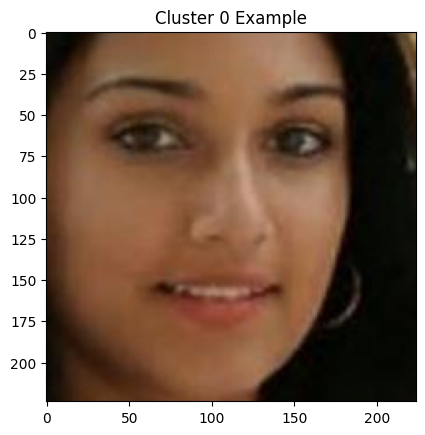

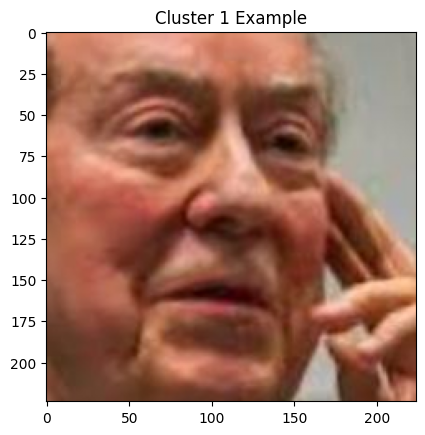

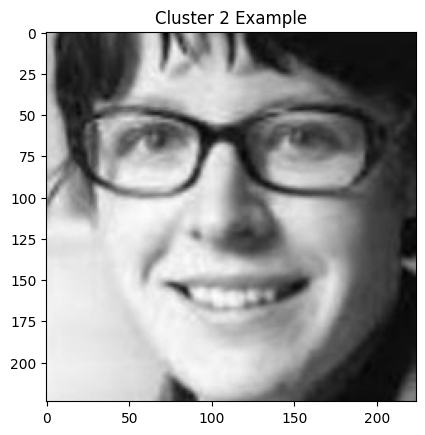

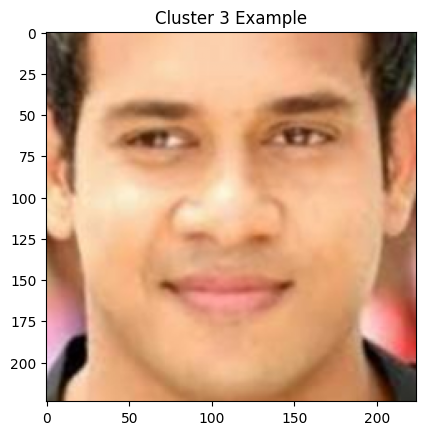

In [10]:
# Visualize examples from each cluster
for cluster in range(4):  # Adjust range if n_clusters changes
    example_index = cluster_df[cluster_df["Cluster"] == cluster].index[0]
    plt.imshow(data[example_index])
    plt.title(f"Cluster {cluster} Example")
    plt.show()


In [11]:
# Proportion of each ethnicity in the dataset
total_ethnicity = cluster_df["Ethnicity"].value_counts(normalize=True)

# Proportion of each ethnicity in each cluster
cluster_ethnicity = cluster_df.groupby("Cluster")["Ethnicity"].value_counts(normalize=True)
# print("Overall Ethnicity Proportion:\n", total_ethnicity)
# print("Cluster Ethnicity Proportion:\n", cluster_ethnicity)

print("Overall Ethnicity Proportion")
display(total_ethnicity)

print("\nCluster Ethnicity Proportion by Cluster")
display(cluster_ethnicity)


Overall Ethnicity Proportion


,proportion
Ethnicity,
0,0.542
2,0.168
3,0.156
4,0.108
1,0.026



Cluster Ethnicity Proportion by Cluster


Cluster  Ethnicity
0        0            0.587940
         2            0.140704
         3            0.130653
         4            0.110553
         1            0.030151
1        0            0.510000
         2            0.200000
         3            0.140000
         4            0.120000
         1            0.030000
2        0            0.368421
         2            0.368421
         3            0.210526
         4            0.052632
3        0            0.527473
         3            0.186813
         2            0.159341
         4            0.104396
         1            0.021978
Name: proportion, dtype: float64

## 6. Conclusion and Next Steps

### My Research question

How do biases in FER datasets and models affect the latent representation of facial expressions across racial groups, and how can unsupervised clustering be used to detect and mitigate these biases?


### Key Findings:
1. Dataset imbalances: White individuals dominate the dataset, while Black individuals are severely underrepresented. The dominance of White individuals in clusters indicates that FER systems trained on imbalanced datasets fail to generalize fairly across races.

2. Cluster biases: Clusters are skewed toward the majority group, reflecting dataset imbalances.

### Recommendations:
1. Balance the dataset by augmenting underrepresented groups.
2. Use fairness-aware training methods to ensure equitable performance across racial groups.

